In [1]:
import json, requests, os, time, scipy
import pandas as pd
from scipy import sparse
from typing import Dict, List
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
from rdkit.Chem import rdFMCS
#import seaborn as sns
RDLogger.DisableLog('rdApp.*')

import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader

from dGbyG.utils.constants import *
from dGbyG.utils.ChemFunc import *
from dGbyG.utils.NNFunc import mol_to_graph_data, one_hot, atom_funs, old_mol_to_graph_data
from dGbyG.config import *
from dGbyG.network.Dataset import Train_Dataset
from dGbyG.network.GNNetwork import MP_network
from dGbyG.network.trainer import Model
from dGbyG.api import Compound, Reaction, predict_standard_dGf_prime, predict_standard_dGr_prime_from_rxn
from dGbyG.config import train_data_path

In [2]:
TrainingData_df = pd.read_csv(train_data_path)
mean_std = TrainingData_df.loc[:,'std'].mean()

Scale = []
for n, sem in zip(TrainingData_df.loc[:,'n'], TrainingData_df.loc[:,'SEM']):
    if np.isnan(sem):
        scale = mean_std
    else:
        scale = (sem**2 + mean_std**2/n)**0.5
    Scale.append(scale)
Scale = np.array(Scale)

equation = TrainingData_df.loc[:, 'reaction']
standard_dG_prime = TrainingData_df.loc[:, 'standard_dg_prime']
weight = 1/np.array(Scale)/np.median(Scale)

In [11]:
Y = []
for i in set(TrainingData_df.type.to_list()):
    y = TrainingData_df.loc[TrainingData_df.type==i, 'standard_dg_prime'].to_numpy()
    Y.append(y)

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_95881/771633364.py:2: SyntaxWarning: invalid escape sequence '\D'
  plt.xticks([0,1], ['$\Delta$$_{0}$G$^{1}$'.format('r', chr(959)), '$\Delta$$_{0}$G$^{1}$'.format('f', chr(959))])
/tmp/ipykernel_95881/771633364.py:2: SyntaxWarning: invalid escape sequence '\D'
  plt.xticks([0,1], ['$\Delta$$_{0}$G$^{1}$'.format('r', chr(959)), '$\Delta$$_{0}$G$^{1}$'.format('f', chr(959))])


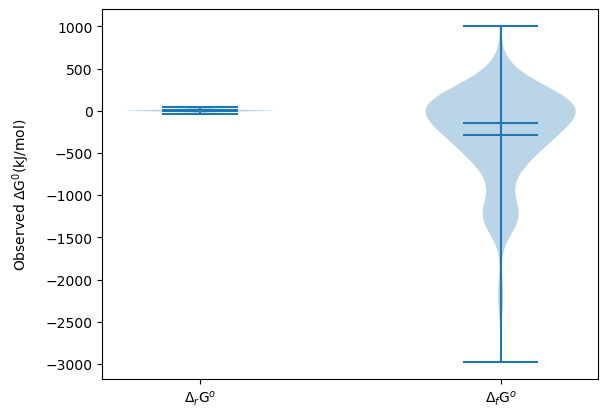

In [26]:
plt.violinplot(Y, [0,1], showmeans=True, showmedians=True)
plt.xticks([0,1], ['$\Delta$$_{0}$G$^{1}$'.format('r', chr(959)), '$\Delta$$_{0}$G$^{1}$'.format('f', chr(959))])

plt.ylabel(r'Observed $\Delta$G$^{0}$(kJ/mol)', labelpad=10)
plt.show()

In [3]:
r = Reaction('C00002 + C00101 + C00025 <=> C00008 + C00009 + C09332', cid_type='kegg')

In [4]:
r.transformed_standard_dGr_prime

(-9.774547576904297, 20.651587)

In [2]:
from collections import namedtuple
AtomInfo = namedtuple('AtomInfo',('mapnum','reactant','reactantAtom','product','productAtom'))
def map_reacting_atoms_to_products(rxn,reactingAtoms):
    ''' figures out which atoms in the products each mapped atom in the reactants maps to '''
    res = []
    for ridx,reacting in enumerate(reactingAtoms):
        reactant = rxn.GetReactantTemplate(ridx)
        for raidx in reacting:
            mapnum = reactant.GetAtomWithIdx(raidx).GetAtomMapNum()
            foundit=False
            for pidx,product in enumerate(rxn.GetProducts()):
                for paidx,patom in enumerate(product.GetAtoms()):
                    if patom.GetAtomMapNum()==mapnum:
                        res.append(AtomInfo(mapnum,ridx,raidx,pidx,paidx))
                        foundit = True
                        break
                    if foundit:
                        break
    return res
def get_mapped_neighbors(atom):
    ''' test all mapped neighbors of a mapped atom'''
    res = {}
    amap = atom.GetAtomMapNum()
    if not amap:
        return res
    for nbr in atom.GetNeighbors():
        nmap = nbr.GetAtomMapNum()
        if nmap:
            if amap>nmap:
                res[(nmap,amap)] = (atom.GetIdx(),nbr.GetIdx())
            else:
                res[(amap,nmap)] = (nbr.GetIdx(),atom.GetIdx())
    return res

BondInfo = namedtuple('BondInfo',('product','productAtoms','productBond','status'))
def find_modifications_in_products(rxn):
    ''' returns a 2-tuple with the modified atoms and bonds from the reaction '''
    reactingAtoms = rxn.GetReactingAtoms()
    amap = map_reacting_atoms_to_products(rxn,reactingAtoms)
    res = []
    seen = set()
    # this is all driven from the list of reacting atoms:
    for _,ridx,raidx,pidx,paidx in amap:
        reactant = rxn.GetReactantTemplate(ridx)
        ratom = reactant.GetAtomWithIdx(raidx)
        product = rxn.GetProductTemplate(pidx)
        patom = product.GetAtomWithIdx(paidx)

        rnbrs = get_mapped_neighbors(ratom)
        pnbrs = get_mapped_neighbors(patom)
        for tpl in pnbrs:
            pbond = product.GetBondBetweenAtoms(*pnbrs[tpl])
            if (pidx,pbond.GetIdx()) in seen:
                continue
            seen.add((pidx,pbond.GetIdx()))
            if not tpl in rnbrs:
                # new bond in product
                res.append(BondInfo(pidx,pnbrs[tpl],pbond.GetIdx(),'New'))
            else:
                # present in both reactants and products, check to see if it changed
                rbond = reactant.GetBondBetweenAtoms(*rnbrs[tpl])
                if rbond.GetBondType()!=pbond.GetBondType():
                    res.append(BondInfo(pidx,pnbrs[tpl],pbond.GetIdx(),'Changed'))
    return amap,res

In [3]:
n = 0
files = os.listdir('/mnt/NFS/fanwc/Recon3D/atomMappingData/atomMappedRxns/')[5201:]
for r_path in tqdm(files):
    r_path = os.path.join('/mnt/NFS/fanwc/Recon3D/atomMappingData/atomMappedRxns', r_path)
    rxn = Chem.AllChem.ReactionFromRxnFile(r_path)
    mols = []
    for mol in list(rxn.GetReactants()) + list(rxn.GetProducts()):
        mol = remove_map_num(mol)
        try:
            comp = Compound(mol)
            mols.append(comp)
        except:
            pass
    #break

  0%|          | 0/2247 [00:00<?, ?it/s]

In [37]:
mols[8].pKa()

IndexError: list index out of range

In [22]:
comp.pKa()

{'acidicValuesByAtom': [{'atomIndex': 39, 'value': 1.75},
  {'atomIndex': 34, 'value': 3.16},
  {'atomIndex': 41, 'value': 7.42},
  {'atomIndex': 17, 'value': 10.16},
  {'atomIndex': 2, 'value': 13.98}],
 'basicValuesByAtom': [{'atomIndex': 13, 'value': 0.47},
  {'atomIndex': 16, 'value': -1.58},
  {'atomIndex': 2, 'value': -3.24},
  {'atomIndex': 23, 'value': -6.74}]}

In [21]:
con2 = default_condition.copy()
con2['pH'] = 7.2

In [13]:
r_path = os.path.join('/mnt/NFS/fanwc/Recon3D/atomMappingData/atomMappedRxns/', 'RE3201C.rxn')
rxn = Chem.AllChem.ReactionFromRxnFile(r_path)

In [15]:
for mol in rxn.GetReactants():
    comp = Compound(mol)

In [22]:
comp.transform(condition1=default_condition, condition2=con2)

6.8193355564596345

In [23]:
comp.standard_dGf_prime

array(189.10577, dtype=float32)

In [25]:
comp.condition = con2
comp.transformed_standard_dGf_prime

195.925

In [ ]:
rxn.Initialize()

In [ ]:
mol

In [ ]:
def map_num_to_idx_with_radius(mol:rdkit.Chem.rdchem.Mol, map_num:tuple, radius:int) -> tuple:
    atoms_idx_radius = [set([atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomMapNum() in map_num]), ]
    print(atoms_idx_radius)
    for r in range(radius):
        atoms_idx_r = set()
        for atom_idx_i in atoms_idx_radius[r]:
            for atom_j in mol.GetAtomWithIdx(atom_idx_i).GetNeighbors():
                atoms_idx_r.add(atom_j.GetIdx())
        for exist_atoms in atoms_idx_radius:
            atoms_idx_r = atoms_idx_r - exist_atoms
        atoms_idx_radius.append(atoms_idx_r)
    print(atoms_idx_radius)
    idxs = set()
    for idxs_set in atoms_idx_radius:
        idxs |= idxs_set

    return tuple(idxs)

In [ ]:
for mol in rxn.GetProducts():
    map_num_to_idx_with_radius(mol, map_num=idx_to_map_num(rxn), radius=2)
    break

In [ ]:
mol

In [ ]:
np.array(range(10))[np.array([1,3,2,8])]

In [3]:
rdkit.__version__

'2023.03.1'

In [ ]:
for atom in mol.GetAtoms():
    print(atom.GetIdx(), atom.GetAtomMapNum())

In [ ]:
mol

In [ ]:
for at in hmol.GetAtoms():
    print(at.GetIdx(), at.GetAtomMapNum())

In [ ]:
at = hmol.GetAtomWithIdx(2)

In [ ]:
at.GetNeighbors()

In [ ]:
Chem.MolToSmiles(hmol)

In [ ]:
ar.GetReactantTemplate(0)

In [ ]:
ar.GetProducts

In [ ]:
ar.GetNumReactantTemplates()

In [ ]:
for r in ar.GetReactants():
    r

In [ ]:
r

In [ ]:
find_modifications_in_products(ar)

In [ ]:
ar.GetNumReactantTemplates()

In [ ]:
ar.GetNumProductTemplates()

In [ ]:
p = ar.GetReactantTemplate(0)
p

In [ ]:
for an in ar.GetReactingAtoms()[0]:
    at = p.GetAtomWithIdx(an)
    print(at.GetIdx(),at.GetSymbol(), at.GetAtomMapNum(), at.GetNumExplicitHs())

In [ ]:
p = ar.GetProductTemplate(0)
p

In [ ]:
pp = deepcopy(p)
[a.ClearProp('molAtomMapNumber') for a in pp.GetAtoms()]
pass

In [ ]:
pp.GetNumAtoms()==p.GetNumAtoms(), pp.GetNumAtoms(), p.GetNumAtoms()

In [ ]:
pp = Chem.AddHs(Chem.MolFromSmiles(Chem.MolToSmiles(pp)))

In [ ]:
pp = pp)

In [ ]:
pp.GetNumAtoms()

In [ ]:
for at in p.GetAtoms():
    pass

In [ ]:
at.GetAtomMapNum()

In [ ]:
s = '*C(=O)N([H])[C@]([H])(C(=O)N(*)[H])C([H])([H])O[H]'
s6 = '[H]N=c1nc(O[H])c2c(n1[H])N([H])C([H])([H])C([H])(C([H])([H])N(C([H])=O)c1c([H])c([H])c(C(=O)N([H])[C@@]([H])(C(=O)O[H])C([H])([H])C([H])([H])C(=NC([H])(C(=O)O[H])C([H])([H])C([H])([H])C(=NC([H])(C(=O)O[H])C([H])([H])C([H])([H])C(=NC([H])(C(=O)O[H])C([H])([H])C([H])([H])C(=NC([H])(C(=O)O[H])C([H])([H])C([H])([H])C(=NC([H])(C(=O)O[H])C([H])([H])C([H])([H])C(=O)O[H])O[H])O[H])O[H])O[H])O[H])c([H])c1[H])N2[H]'
s7 = '[H]N=c1nc(O[H])c2c(n1[H])N([H])C([H])([H])C([H])(C([H])([H])N(C([H])=O)c1c([H])c([H])c(C(=O)N([H])C([H])(C(=O)O[H])C([H])([H])C([H])([H])C(=O)N([H])C([H])(C(=O)N([H])C([H])(C(=O)N([H])C([H])(C(=O)N([H])C([H])(C(=O)N([H])C([H])(C(=O)N([H])C([H])(C(=O)O[H])C([H])([H])C([H])([H])C(=O)O[H])C([H])([H])C([H])([H])C(=O)O[H])C([H])([H])C([H])([H])C(=O)O[H])C([H])([H])C([H])([H])C(=O)O[H])C([H])([H])C([H])([H])C(=O)O[H])C([H])([H])C([H])([H])C(=O)O[H])c([H])c1[H])N2[H]'
#s = '[H]OC1=NC(=N[H])N([H])C2=C1N([H])C([H])(C([H])([H])N(C([H])=O)C1=C([H])C([H])=C(C([H])=C1[H])C(=O)N([H])C([H])(C([O-])=O)C([H])([H])C([H])([H])C(=O)N([H])C([H])(C(=O)N([H])C([H])(C(=O)N([H])C([H])(C(=O)N([H])C([H])(C(=O)N([H])C([H])(C(=O)N([H])C([H])(C([O-])=O)C([H])([H])C([H])([H])C([O-])=O)C([H])([H])C([H])([H])C([O-])=O)C([H])([H])C([H])([H])C([O-])=O)C([H])([H])C([H])([H])C([O-])=O)C([H])([H])C([H])([H])C([O-])=O)C([H])([H])C([H])([H])C([O-])=O)C([H])([H])N2[H]'
#s = '[H]OC(=O)C([H])([H])C([H])([H])[C@@]([H])(C(=O)O[H])N([H])[H]'
#s = '[H]O[H]'
mol6 = to_mol(s6, 'smiles')
mol7 = to_mol(s7, 'smiles')
#mol = to_mol('C00080', cid_type='kegg')

In [ ]:
res=rdFMCS.FindMCS([mol6, mol7])

In [ ]:
molFe = to_mol('[Fe+3]', 'smiles')

In [ ]:
molFe

In [ ]:
rdMolStandardize.Uncharger().uncharge(molFe)

In [ ]:
te = rdMolStandardize.TautomerEnumerator() # idem
clean_mol = te.Canonicalize(mol)

In [ ]:
clean_mol

In [ ]:
m = Compound(mol)

In [ ]:
m.standard_dGf_prime

In [ ]:
predict_standard_dGf_prime(clean_mol)

In [ ]:
3137-2307-577+158

In [ ]:
r = 'C00080 = C00001'

In [ ]:
r = Reaction(r, cid_type='kegg')

In [ ]:
a = predict_standard_dGf_prime(mol)

In [ ]:
trainingData_df = pd.read_csv(train_data_path).iloc[1:,:]

mean_std = trainingData_df.loc[:,'stderr'].mean()
SEM = np.nan_to_num(trainingData_df.loc[:,'SEM'], nan=mean_std)
weight = (1/(SEM+1))/np.median((1/(SEM+1)))
trainingData_df.loc[:,'weight'] = weight

TrainSet = Train_Dataset(trainingData_df, equation_column='reaction', dG_column='standard_dg_prime', weight_column='weight')

In [ ]:
for n, atom in enumerate(m.mol.GetAtoms()):
    print(n, atom)
    break

In [ ]:
x = mol_to_graph_data(m.mol, atom_features=['atomic number', 'hybridization', 'aromaticity', 'charge'], bond_features=['bond type'])

In [ ]:
x.edge_index

In [ ]:
from torch_geometric.utils import add_self_loops

In [ ]:
ax,aa = add_self_loops(x.edge_index, num_nodes=x.x.size(0), edge_attr=x.edge_attr)

In [ ]:
ax

In [ ]:
e = torch.nn.Embedding(3,2)

In [ ]:
a = torch.tensor([0,1,2])
e(a)

In [ ]:
a.shape, e(a).shape

In [ ]:
e.weight

In [ ]:
def one_hot(num, index):
    vector = [0] * num
    vector[index] = 1
    return vector

In [ ]:
t  = one_hot(3,2)

In [ ]:
t

In [ ]:
t.shape

In [ ]:
torch.cat([t,t,t],dim=0)

In [ ]:
a = torch.tensor([0,1,2], dtype=torch.float32)

In [ ]:
l = nn.Linear(3,2, bias=False)

In [ ]:
l.weight

In [ ]:
l(a)

In [ ]:
mol_to_graph_data(m.mol).x.

In [ ]:
adj = Chem.GetAdjacencyMatrix(m.mol)

In [ ]:
coo = sparse.coo_matrix(adj)

In [ ]:
coo.row

In [ ]:
coo.col

In [ ]:
m.standard_dGf_prime

In [ ]:
m.transformed_standard_dGf_prime

In [ ]:
m.condition

In [ ]:
default_condition

In [ ]:
mm = m.mol
atom = mm.GetAtomWithIdx(4)
print(atom.GetSymbol())
atom.SetFormalCharge(0)
atom.GetNumExplicitHs()
atom.GetNumImplicitHs()
atom.SetNumExplicitHs(0)
Chem.SanitizeMol(mm)

In [ ]:
r = {'[H+]': -1.0, '[Fe+2]': -1.0}
#r = 'C01644 = C00001'

In [ ]:
R = Reaction(r, rxn_type='dict', cid_type='smiles')

In [ ]:
R.products

In [ ]:
sum(R.substrates.values())

In [ ]:
a = R.rxn

In [ ]:
R.is_balanced()

In [ ]:
R.transformed_standard_dGr_prime

In [ ]:
R.transformed_standard_dGr_prime

In [ ]:
R.equationSmiles

In [ ]:
R.is_balanced(ignore_H2O=False)

In [ ]:
m0 = Compound(to_mol('[H]OC1([H])C([H])(n2c([H])nc3c(N([H])[H])nc([H])nc32)OC([H])(C([H])([H])OP(=O)(O[H])OP(=O)([O-])OC([H])([H])C2([H])OC([H])([n+]3c([H])c([H])c([H])c(C(=O)C([H])([H])[H])c3[H])C([H])(O[H])C2([H])O[H])C1([H])O[H]', cid_type='smiles'))

In [ ]:
m0

In [ ]:
Compound(m0).Smiles

In [ ]:
normalize_mol(m0)

In [ ]:
rdMolStandardize.StandardizeSmiles('[H]OC1([H])C([H])(n2c([H])nc3c(N([H])[H])nc([H])nc32)OC([H])(C([H])([H])OP(=O)(O[H])OP(=O)([O-])OC([H])([H])C2([H])OC([H])([n+]3c([H])c([H])c([H])c(C(=O)C([H])([H])[H])c3[H])C([H])(O[H])C2([H])O[H])C1([H])O[H]')

In [ ]:
m0

In [ ]:
Compound(m0).Smiles

In [ ]:
u = rdMolStandardize.Uncharger()
m00 = u.uncharge(m0)

In [ ]:
Chem.AddHs(m00)

In [ ]:
Compound(Chem.AddHs(m00)).Smiles

In [ ]:
Chem.MolToSmiles(m0, allHsExplicit=True)

In [ ]:
Chem.MolToSmiles(m0)

In [ ]:
rdMolStandardize.Normalize(m0, )

In [ ]:
a = rdMolStandardize.ChargeParent(m0)

In [ ]:
Chem.MolToSmiles(a)

In [ ]:
Chem.MolToSmiles(m0)

In [ ]:
a = os.popen(f"cxcalc pKa -t acidic,basic -a 8 -b 8 test.smi")
with open('test.tsv', 'w') as f:
    f.write(a.read())


In [ ]:
s = [x.strip() for x in open('test.smi', 'r').readlines()]

In [ ]:
p = pd.read_csv('test.tsv', sep='\t').drop(columns='id')
p.index = s
p = p.reset_index()
p = p.rename(columns={'index':'smiles'})

In [ ]:
op = pd.read_csv(chemaxon_pka_csv_path)
p = pd.concat([op,p])

In [ ]:
p = p.drop_duplicates()

In [ ]:
p.to_csv(chemaxon_pka_csv_path, index=False)

In [ ]:
m = to_mol('C00033', cid_type='kegg')
#m = to_mol('[Fe]', cid_type='smiles')

In [ ]:
m = Compound(m)

In [ ]:
Reaction(m.Smiles).rxnSmiles

In [ ]:
m.ddGf()

In [ ]:
get_pKa(m, source='file')